In [49]:
import pysam
from collections import defaultdict, namedtuple
from tqdm import tqdm_notebook
import gc
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pygraphviz as pvg
import matplotlib.pyplot as plt
from os import path
from time import time
from copy import deepcopy
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class Node:
    
    def __init__(self, name):
        self.name = name
        self.indegree = 0
        self.outdegree = 0
        self.in_edges = []
        self.out_edges = []
        
        #Deepcopies for experimenting
        #Implement later
        self.tv_edges = None
        self.tv_nodes = None
    
class Edge:
    
    def __init__(self, elen, cov=0):
        self.cov = cov
        self.len = elen

class DeBruijn:
    
    def __init__(self, data, k):
        self.k = k
        self.data = data
        self.format = data[-data[::-1].find('.'):]
        self.nodes = {}
        self.edges = defaultdict(lambda: Edge(self.k+1))
        self.vised = False
    
    def get_rev_comp(self, string):
        comp_dic = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        rev_comp = ''.join([comp_dic[ch] for ch in string][::-1])
        return rev_comp
    
    def add_node(self, string):
        self.nodes[string] = Node(string)
    
    def add_edge(self, string):
        self.edges[string].cov += 1
        if self.edges[string].cov == 1:
            self.nodes[string[:-1]].outdegree += 1
            self.nodes[string[:-1]].out_edges.append(string)
            self.nodes[string[1:]].indegree += 1
            self.nodes[string[1:]].in_edges.append(string)
    
    def add_nodes_fasta(self):
        with pysam.FastaFile(self.data) as file:
            for read_id in tqdm_notebook(file.references):
                sequence = file.fetch(read_id)
                
                for i in range(len(sequence) - self.k + 1):
                    kmer = sequence[i:i+self.k]
                    rev_kmer = self.get_rev_comp(kmer)
                    if not (kmer in self.nodes):
                        self.add_node(kmer)
                        self.add_node(rev_kmer)
        
    def add_edges_fasta(self):
        with pysam.FastaFile(self.data) as file:
            for read_id in tqdm_notebook(file.references):
                sequence = file.fetch(read_id)
                
                for i in range(len(sequence) - self.k):
                    kmer = sequence[i:i+self.k+1]
                    rev_kmer = self.get_rev_comp(kmer)
                    self.add_edge(kmer)
                    self.add_edge(rev_kmer)
                    
    def add_nodes_fastq(self):
        with pysam.FastqFile(self.data) as file:
            for read in tqdm_notebook(file):  
                sequence = read.sequence
                
                for i in range(len(sequence) - self.k + 1):
                    kmer = sequence[i:i+self.k]
                    rev_kmer = self.get_rev_comp(kmer)
                    if not (kmer in self.nodes):
                        self.add_node(kmer)
                        self.add_node(rev_kmer)
        
    def add_edges_fastq(self):
        with pysam.FastqFile(self.data) as file:
            for read in tqdm_notebook(file):
                sequence = read.sequence
                
                for i in range(len(sequence) - self.k):
                    kmer = sequence[i:i+self.k+1]
                    rev_kmer = self.get_rev_comp(kmer)
                    self.add_edge(kmer)
                    self.add_edge(rev_kmer)
                
    def construct(self):
        if self.format == 'fasta':
            self.add_nodes_fasta()
            self.add_edges_fasta()
        elif self.format == 'fastq':
            self.add_nodes_fastq()
            self.add_edges_fastq()
        else:
            raise ValueError('Wrong file format')
        
    def merge_edges(self, node):
        
        o_edge_id = node.out_edges[0]
        i_edge_id = node.in_edges[0]
        o_edge = self.edges[o_edge_id]
        i_edge = self.edges[i_edge_id]
        
        n_edge = i_edge_id + o_edge_id[self.k:]
        n_cov = o_edge.cov + i_edge.cov
        n_len = i_edge.len + o_edge.len - self.k
        
        self.nodes[o_edge_id[-self.k:]].in_edges.remove(o_edge_id)
        self.nodes[o_edge_id[-self.k:]].in_edges.append(n_edge)
        self.nodes[i_edge_id[:self.k]].out_edges.remove(i_edge_id)
        self.nodes[i_edge_id[:self.k]].out_edges.append(n_edge)
        
        self.edges[n_edge] = Edge(n_len, n_cov)
        
        del self.nodes[node.name]
        del self.edges[o_edge_id]
        del self.edges[i_edge_id]
        
    def compress(self):
        nl = list(self.nodes.keys())
        for node_name in tqdm_notebook(nl):
            node = self.nodes[node_name]
            if (node.indegree == 1) and (node.outdegree == 1):
                self.merge_edges(node)
        gc.collect()
        for edge in self.edges:
            self.edges[edge].cov = round(self.edges[edge].cov/(self.edges[edge].len - self.k))
        self.node_names = {name: i for i, name in enumerate(self.nodes.keys())}
    
    def vis(self):
        self.graph = pvg.AGraph(strict=False, directed=True)
        added = []
        for name, v in self.edges.items():
            ls = f'Length: {v.len}\nCoverage: {v.cov}'
            self.graph.add_edge(self.node_names[name[:self.k]], 
                                self.node_names[name[-self.k:]], 
                                label=ls)
            added.append(name[:self.k])
            added.append(name[-self.k])
        '''    
        for n_name in node_names:
            if not (n_name in added):
                self.graph.add_node(node_names[n_name])
        '''
        self.vised = True
            
    def cov_and_len_dist(self, bins=10, joint=True):
        covs = []
        lens = []
        for _, edge in self.edges.items():
            covs.append(edge.cov)
            lens.append(edge.len)
            
        covs = np.array(covs)
        lens = np.array(lens)
        
        if not joint:
            fig, axarr = plt.subplots(1, 2, figsize = [16, 9])
            fig.suptitle('Coverage and length of edges')
            axarr[0].hist(covs, bins=bins)
            axarr[0].set_xlabel('Coverage')
            axarr[1].hist(lens, bins=bins)
            axarr[1].set_xlabel('Length')
        else:
            (sns.jointplot(x=covs, y=lens)).\
            set_axis_labels('Coverage', 'Length')

    def cut_tips(self, cov_cut, len_cut):
        self.vised = False
        modded = True
        while modded != 0:
            modded = 0
            items = list(self.nodes.items())
            for node_name, node in items:
                if (node.outdegree + node.indegree) == 1:
                    assert(len(node.in_edges + node.out_edges) == 1)
                    edge_name = (node.in_edges + node.out_edges)[0]
                    edge = self.edges[edge_name]
                    if (edge.cov <= cov_cut) and (edge.len <= len_cut):
                        if node.outdegree == 1:
                            self.nodes[edge_name[-self.k:]].in_edges.remove(edge_name)
                            self.nodes[edge_name[-self.k:]].indegree -= 1
                            if self.nodes[edge_name[-self.k:]].outdegree == 0:
                                del self.nodes[edge_name[-self.k:]]
                            self.nodes[node_name].out_edges = []
                            self.nodes[node_name].outdegree = 0
                        elif node.indegree == 1:
                            self.nodes[edge_name[:self.k]].out_edges.remove(edge_name)
                            self.nodes[edge_name[:self.k]].outdegree -= 1
                            if self.nodes[edge_name[:self.k]].indegree == 0:
                                del self.nodes[edge_name[:self.k]]
                            self.nodes[node_name].in_edges = []
                            self.nodes[node_name].indegree = 0
                        
                        del self.nodes[node_name]
                        
                        del self.edges[edge_name]
                        modded += 1
        
    def cut_all_low(self, cov_cut, len_cut):
        self.vised = False
        items = list(self.nodes.items())
        for node_name, node in items:
            if (node.indegree + node.outdegree) != 0:
                edge_name = (node.in_edges + node.out_edges)[0]
                edge = self.edges[edge_name] 
                if (edge.cov <= cov_cut) and (edge.len <= len_cut):

                    self.nodes[edge_name[:self.k]].out_edges.remove(edge_name)
                    self.nodes[edge_name[:self.k]].outdegree -= 1

                    self.nodes[edge_name[-self.k:]].in_edges.remove(edge_name)
                    self.nodes[edge_name[-self.k:]].indegree -= 1

                    del self.edges[edge_name]
            else:
                #maybe delete such node?
                #or do it later
                pass
                
    def write_to_fasta(self, output):
        records = (SeqRecord(Seq(k, 'DNA'), str(i)) for i, k in enumerate(self.edges))
        SeqIO.write(records, output, 'fasta')
    
    def draw(self, output):
        if not self.vised:
            self.vis()
        self.graph.draw(output, prog='dot')
    
    def write_to_dot(self, output):
        if not self.vised:
            self.vis()
        self.graph.write(output)

Setting up paths to data:

In [3]:
test_1 = 'Data/Assignment_5/test1.fasta'
test_2 = 'Data/Assignment_5/test2.fasta'

ec1 = 'Data/Assignment_5/ECOLI_IS220_QUAKE_1K_single_reads.fasta'
ec2 = 'Data/Assignment_5/ECOLI_IS220_QUAKE_1K_paired_reads.fasta'

f1 = 'Data/Assignment_5/s_6.first1000.fastq'
f2 = 'Data/Assignment_5/s_6.first10000.fastq'
f3 = 'Data/Assignment_5/s_6.first100000.fastq'

In [73]:
res_f_path = 'FASTA/'
res_i_path = 'Images/'
res_d_path = 'DOT_files/'

## 1k data:

In [50]:
s = time()
g = DeBruijn(f1, 55)
g.construct()
g.compress()
print(f'{round(time() - s, 3)} seconds')


1.407 seconds


In [11]:
g.draw(path.join(res_i_path, '1k.png'))

Here is the raw compressed graph:


![image](Images/1k.png)

Cutting tips only:

In [12]:
g.cut_tips(cov_cut=250, len_cut=200)

In [13]:
g.draw(path.join(res_i_path, '1k_prunned.png'))

![image](Images/1k_prunned.png)

Cutting all short edges with low coverage.

In [14]:
g.cut_all_low(cov_cut=250, len_cut=200)

In [15]:
g.draw(path.join(res_i_path, '1k_allcut.png'))

![image](Images/1k_allcut.png)

Graphs above illustrate why it is more reasonable to cut only the tips and not all the edges with low coverage and length. Sometimes edges that connect parts of the genome we assembly are connected with such edges. If they are deleted the assembly graph breaks into small components.

## 10k data:

In [52]:
s = time()
g = DeBruijn(f2, 55)
g.construct()
g.compress()
print(f'{round(time() - s, 3)} seconds')


18.792 seconds


In [53]:
g.draw(path.join(res_i_path, '10k.png'))

![image](Images/10k.png)

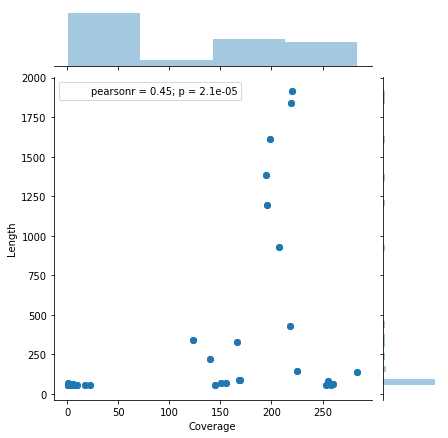

In [54]:
g.cov_and_len_dist()

In [58]:
g.cut_tips(cov_cut=150, len_cut=250)

In [59]:
g.draw(path.join(res_i_path, '10k_prunned.png'))

![image](Images/10k_prunned.png)

Again, let's see what will happen if we trim all the low covered short edges:

In [60]:
g.cut_all_low(cov_cut=150, len_cut=250)

In [61]:
g.draw(path.join(res_i_path, '10k_allcut.png'))

![image](Images/10k_allcut.png)

## 100k data:

In [62]:
g = DeBruijn(f3, 55)

In [63]:
s = time()
g.construct()
g.compress()
print(f'{round(time() - s, 3)} seconds')


219.274 seconds


In [64]:
g.draw(path.join(res_i_path, '100k.png'))

![image](Images/100k.png)

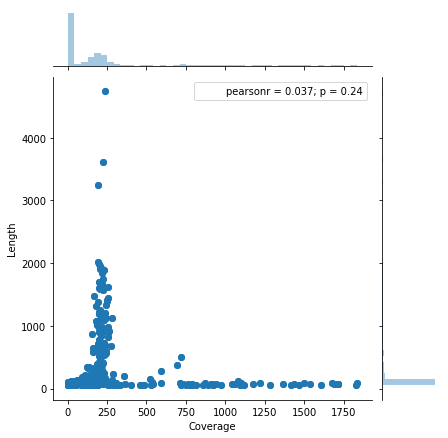

In [65]:
g.cov_and_len_dist()

In [66]:
g.cut_tips(cov_cut=250, len_cut=250)

In [67]:
g.draw(path.join(res_i_path, '100k_prunned.png'))

![image](Images/100k_prunned.png)

Edges of the resulting graph can be imported to .fasta file:

In [68]:
g.write_to_fasta(path.join(res_f_path, '100k_prunned.fasta'))

And also to .dot file format:

In [69]:
g.write_to_dot(path.join(res_d_path, '100k_prunned.dot'))